In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    #data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 1000
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
sym = 'NQ'
start_date='20180901'
end_date='20191231'
periods=[5,10,20,40,80,160]
s='20180501'
params = {
    'bolli_reduced': calibrate_multiple(sym, bolli_reduced, start_date=s),
    'ema': calibrate_multiple(sym, ema, start_date=s),
    'breakout': calibrate_multiple(sym, breakout, start_date=s),
    'carver': calibrate_multiple(sym, carver, start_date=s),
    'roc': calibrate_multiple(sym, roc, start_date=s)
}
params_s = {}
inds_s = {}
for i in [bolli_reduced, ema, breakout, carver, roc]:
    tup = run(sym, i, start_date=start_date, end_date=end_date, periods=periods, save_params=True)
    params_s[i.__name__] = tup[1]
    inds_s[i.__name__] = tup[0]
"""
inds_s = {
        'bolli_reduced': run(sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
        #'ema': run(sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
        'breakout': run(sym, breakout, start_date=start_date, end_date=end_date, periods=periods),
        'carver': run(sym, carver, start_date=start_date, end_date=end_date, periods=periods),
        'roc': run(sym, roc, start_date=start_date, end_date=end_date, periods=periods)
}
"""
start_date = '20190101'
inds_c = {
    'bolli_reduced': simulate(params['bolli_reduced'], sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
    'ema': simulate(params['ema'], sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    'breakout': simulate(params['breakout'], sym, breakout, start_date=start_date, end_date=end_date, periods=periods),
    'carver': simulate(params['carver'], sym, carver, start_date=start_date, end_date=end_date, periods=periods),
    'roc': simulate(params['roc'], sym, roc, start_date=start_date, end_date=end_date, periods=periods)
}
weights = {
    'bollir': .5, 
    'ema': .25, 
    'breakout': .25,
    #'carver': .1,
    #'roc': .1,
}


In [10]:
params

{'bolli_reduced': (bolli_reduced_5      0.204877
  bolli_reduced_10     0.153504
  bolli_reduced_20     0.137353
  bolli_reduced_40     0.137260
  bolli_reduced_80     0.153855
  bolli_reduced_160    0.213150
  dtype: float64, bolli_reduced_5      26.404546
  bolli_reduced_10     14.905309
  bolli_reduced_20     10.875295
  bolli_reduced_40      9.388274
  bolli_reduced_80      8.970328
  bolli_reduced_160     8.955797
  dtype: float64, 1.5300027981169197), 'ema': (ema_5      0.192347
  ema_10     0.149686
  ema_20     0.134282
  ema_40     0.136561
  ema_80     0.159155
  ema_160    0.227970
  dtype: float64, ema_5      11.062181
  ema_10      7.941667
  ema_20      5.639814
  ema_40      3.843982
  ema_80      2.771818
  ema_160     2.086510
  dtype: float64, 1.2623494960013555), 'breakout': (break_5      0.210944
  break_10     0.155669
  break_20     0.139221
  break_40     0.138401
  break_80     0.152160
  break_160    0.203605
  dtype: float64, break_5       17.726329
  break_10

In [11]:
params_s

{'bolli_reduced': (bolli_reduced_5      0.210274
  bolli_reduced_10     0.158443
  bolli_reduced_20     0.139770
  bolli_reduced_40     0.137836
  bolli_reduced_80     0.153590
  bolli_reduced_160    0.200087
  dtype: float64, bolli_reduced_5      26.148828
  bolli_reduced_10     14.804989
  bolli_reduced_20     10.697725
  bolli_reduced_40      8.693681
  bolli_reduced_80      7.779091
  bolli_reduced_160     7.202572
  dtype: float64, 1.5186369170491913,                    bolli_reduced_5  bolli_reduced_10  bolli_reduced_20  \
  bolli_reduced_5           1.000000          0.742863          0.450624   
  bolli_reduced_10          0.742863          1.000000          0.807991   
  bolli_reduced_20          0.450624          0.807991          1.000000   
  bolli_reduced_40          0.223606          0.487597          0.806671   
  bolli_reduced_80          0.090671          0.229416          0.489224   
  bolli_reduced_160         0.009580          0.072980          0.232667   
  
      

In [12]:
for keys, values in zip(params_s.items(), params.items()):

SyntaxError: unexpected EOF while parsing (<ipython-input-12-d83b64e77d41>, line 1)

In [ ]:
def param_printer(n):
    names = {0: 'weights', 1: 'adjustments', 2: 'multiplier'}
    for i in ['bolli_reduced', 'ema', 'breakout', 'carver', 'roc']:
        print(f'\n{names[n]} {i}\n')
        if isinstance(params[i][n], pd.Series):
            print(pd.DataFrame({'combined': params[i][n], 'single': params_s[i][n]}))
        else:
            print(pd.Series({'combined': params[i][n], 'single': params_s[i][n]}))

In [ ]:
for n in range(3):
    param_printer(n)

In [37]:
inds = inds_s

In [38]:
out = pd.DataFrame(columns=['mean', 'std'])
for key, ind in inds.items():
    out.loc[key, 'mean'] = ind.forecast.abs().mean()
    out.loc[key, 'std'] = ind.forecast.abs().std()
out

,mean,std
bolli_reduced,9.44885,6.14565
ema,10.6112,6.0958
breakout,9.14897,6.38323
carver,7.43325,4.87133
roc,8.39516,5.43263


In [39]:
c=pd.DataFrame({key: ind.forecast for key, ind in inds.items()}).corr()
c

,bolli_reduced,ema,breakout,carver,roc
bolli_reduced,1.000000,0.765716,0.935018,0.935108,0.917467
ema,0.765716,1.000000,0.713685,0.792668,0.887675
breakout,0.935018,0.713685,1.000000,0.918671,0.869291
carver,0.935108,0.792668,0.918671,1.000000,0.925969
roc,0.917467,0.887675,0.869291,0.925969,1.000000


In [40]:
c.sum()

bolli_reduced    4.553310
ema              4.159744
breakout         4.436665
carver           4.572417
roc              4.600403
dtype: float64

In [41]:
def combine(inds, weights=None):
    if weights is None:
        weights = {key: 1/len(inds) for key in inds.keys()}
    assert round(sum(weights.values()),4) == 1.0, "Weights don't add up to 1"
    df = pd.DataFrame({name: df.forecast for name, df in inds.items()})
    df['forecast'] = (df*pd.Series(weights)).sum(axis=1)
    df[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    #multiplier = 10/df.forecast.abs().std()
    multiplier = 1
    df['forecast'] = df.forecast * multiplier
    return df.dropna()

In [42]:
data=combine(inds,)

In [43]:
combine(inds_c)

,bolli_reduced,ema,breakout,carver,roc,forecast,open,close
date,,,,,,,,
2019-01-09 16:43:00,4.214222,12.807815,6.763325,7.681357,14.000415,9.093427,6606.50,6573.50
2019-01-09 17:01:00,9.839745,12.411717,11.156632,9.988408,15.262151,11.731731,6573.50,6587.50
2019-01-09 17:24:00,16.137534,12.899074,20.000000,15.460271,17.826382,16.464652,6587.50,6606.75
2019-01-09 17:51:00,16.627456,13.450529,20.000000,16.602004,19.841597,17.304317,6606.75,6612.25
2019-01-09 18:23:00,17.609327,14.001685,20.000000,17.263981,19.461750,17.667349,6612.50,6618.25
...,...,...,...,...,...,...,...,...
2019-09-04 16:21:00,4.434324,5.092706,-3.607876,1.157181,6.474254,2.710118,7689.50,7677.50
2019-09-04 16:49:00,4.587939,4.615203,1.442268,0.243667,4.811666,3.140149,7677.50,7679.50
2019-09-04 17:24:00,4.389396,4.534098,1.158491,1.848446,5.389078,3.463902,7679.50,7686.00


In [44]:
comp = pd.DataFrame({'single': combine(inds_s)['forecast'], 'combined': combine(inds_c)['forecast']})
comp

,single,combined
date,,
2019-01-02 00:00:00,6.753202,NaN
2019-01-02 03:34:00,1.244533,NaN
2019-01-02 07:31:00,-5.232335,NaN
2019-01-02 09:26:00,-9.418859,NaN
2019-01-02 10:45:00,-8.449593,NaN
...,...,...
2019-09-04 17:05:00,3.165713,NaN
2019-09-04 17:24:00,NaN,3.463902
2019-09-04 17:39:00,6.307388,NaN


In [45]:
comp.iloc[500:].head(50)

,single,combined
date,,
2019-01-22 20:21:00,NaN,-6.015679
2019-01-22 20:26:00,-8.509141,NaN
2019-01-22 20:44:00,NaN,-10.757284
2019-01-22 20:49:00,-11.172911,NaN
2019-01-22 21:04:00,NaN,-11.214379
2019-01-22 21:10:00,-10.986931,NaN
2019-01-22 21:24:00,NaN,-7.703026
2019-01-22 21:36:00,-8.937002,NaN
2019-01-22 21:40:00,NaN,-3.825894


In [54]:
comp.loc['20190201': '20190228'].iloc[150:].head(50)

,single,combined
date,,
2019-02-07 15:30:00,-3.774904,-3.474764
2019-02-07 15:37:00,NaN,-4.243785
2019-02-07 15:38:00,-4.473268,NaN
2019-02-07 15:47:00,NaN,-2.110153
2019-02-07 15:49:00,-4.935583,NaN
2019-02-07 15:58:00,NaN,-0.403465
2019-02-07 16:02:00,-1.890560,NaN
2019-02-07 16:11:00,NaN,2.199769
2019-02-07 16:18:00,1.177926,NaN


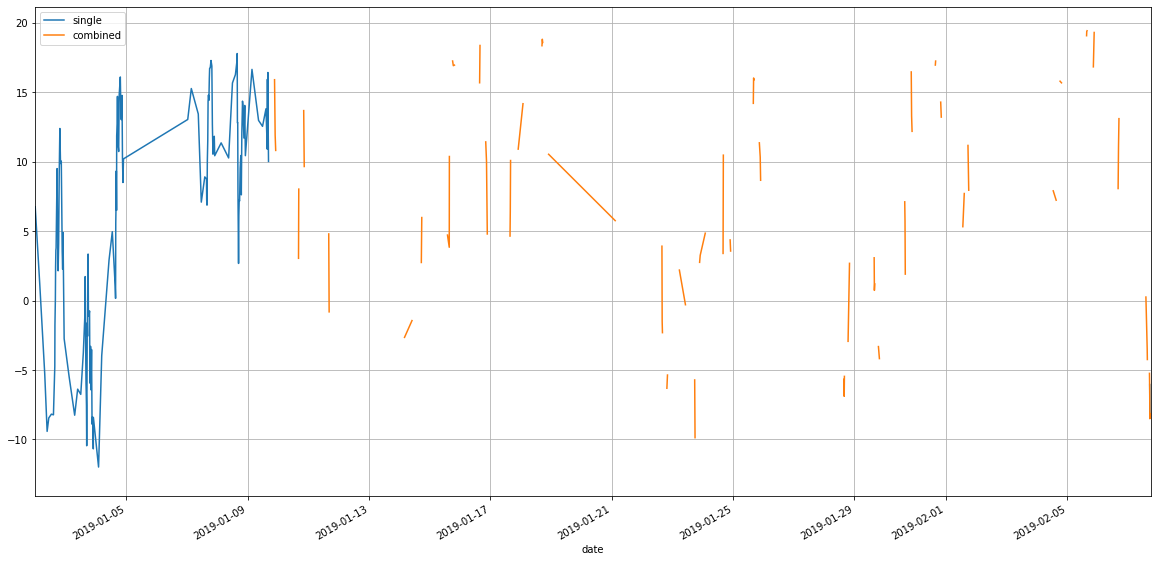

In [46]:
comp.iloc[:1000].plot(figsize=(20,10), grid=True);

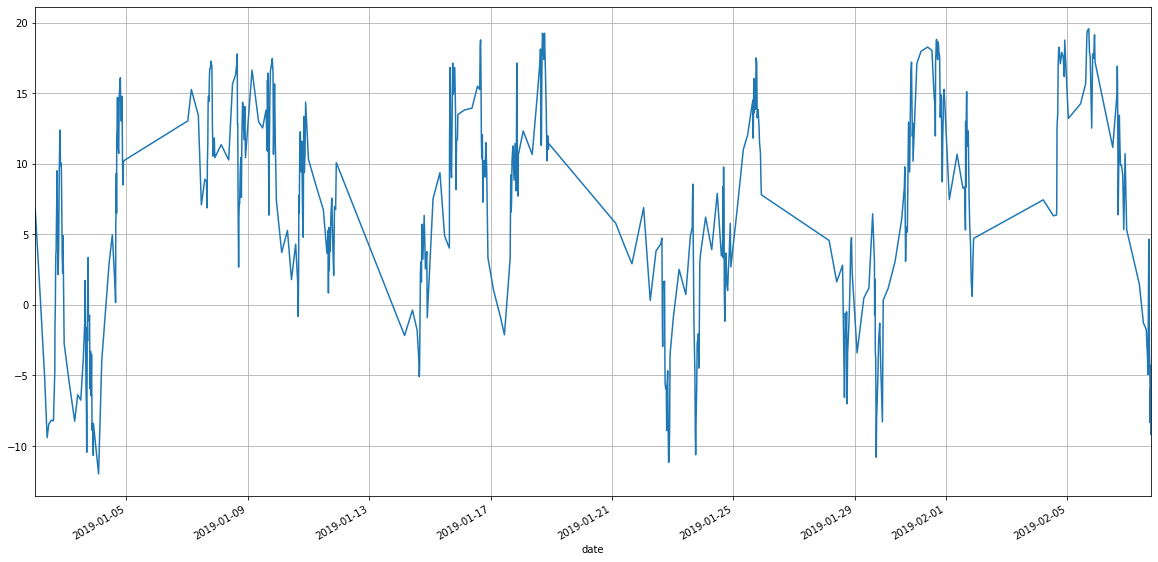

In [61]:
comp.iloc[:1000]['single'].dropna().plot(figsize=(20,10), grid=True);

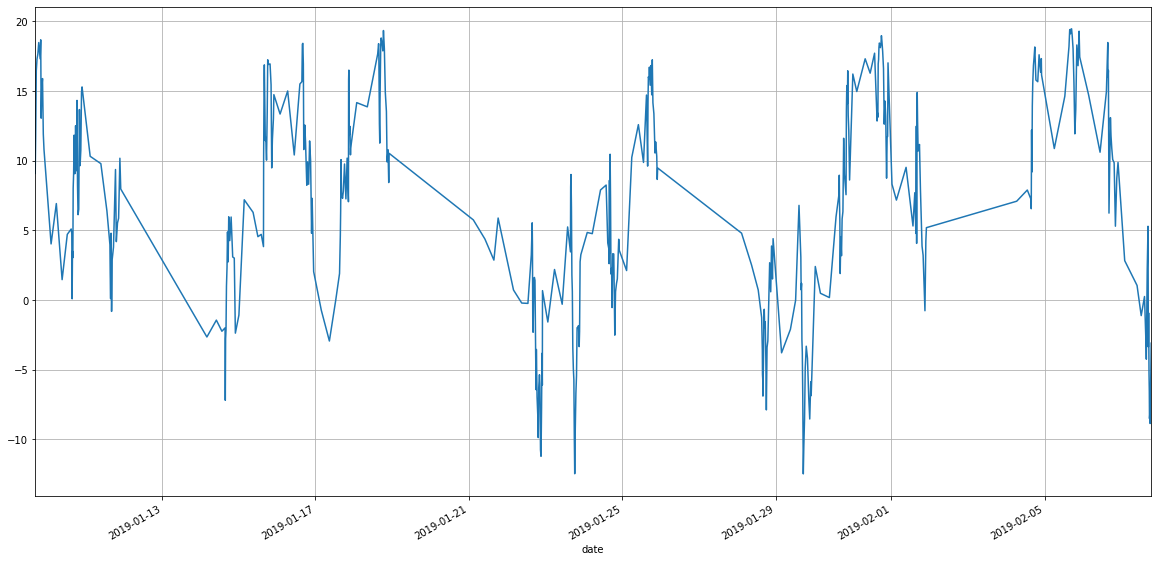

In [62]:
comp.iloc[:1000]['combined'].dropna().plot(figsize=(20,10), grid=True);

In [60]:
comp.single.dropna().iloc[300:].head(50)

date
2019-01-21 15:50:00     2.909842
2019-01-22 01:05:00     6.889902
2019-01-22 06:17:00     0.313537
2019-01-22 10:53:00     3.815542
2019-01-22 14:35:00     4.311317
2019-01-22 15:30:00     4.719622
2019-01-22 15:40:00     2.713779
2019-01-22 15:53:00    -1.178164
2019-01-22 16:07:00    -2.958318
2019-01-22 16:22:00     1.103373
2019-01-22 16:43:00     1.646824
2019-01-22 17:07:00     1.282347
2019-01-22 17:37:00     1.675469
2019-01-22 17:53:00    -4.011247
2019-01-22 18:05:00    -5.634282
2019-01-22 18:30:00    -5.942753
2019-01-22 18:59:00    -5.754410
2019-01-22 19:18:00    -8.912232
2019-01-22 19:36:00    -5.696276
2019-01-22 20:06:00    -4.678678
2019-01-22 20:26:00    -8.509141
2019-01-22 20:49:00   -11.172911
2019-01-22 21:10:00   -10.986931
2019-01-22 21:36:00    -8.937002
2019-01-22 21:45:00    -6.173670
2019-01-22 21:58:00    -3.512418
2019-01-23 00:38:00    -0.836569
2019-01-23 05:07:00     2.508662
2019-01-23 10:25:00     0.727140
2019-01-23 14:01:00     4.867722
2019-

In [59]:
data.iloc[300:].head(50)

,bolli_reduced,ema,breakout,carver,roc,forecast,open,close
date,,,,,,,,
2019-01-21 15:50:00,-1.454637,13.007348,-2.351563,0.555074,4.792990,2.909842,6754.25,6747.75
2019-01-22 01:05:00,4.757470,13.271844,4.524709,4.875694,7.019792,6.889902,6748.25,6773.75
2019-01-22 06:17:00,-5.985862,11.426183,-5.101466,-0.234532,1.463362,0.313537,6773.25,6732.25
2019-01-22 10:53:00,0.667407,10.805340,2.608025,0.651762,4.345175,3.815542,6732.00,6741.75
2019-01-22 14:35:00,1.716542,10.412115,3.738823,0.019941,5.669162,4.311317,6741.75,6741.00
2019-01-22 15:30:00,2.816522,10.316131,4.245393,0.174146,6.045919,4.719622,6740.75,6743.75
2019-01-22 15:40:00,-0.153890,9.779151,4.424506,-2.317217,1.836345,2.713779,6743.75,6732.75
2019-01-22 15:53:00,-7.316721,8.700898,-6.041556,-3.519836,2.286394,-1.178164,6732.75,6716.25
2019-01-22 16:07:00,-7.515072,7.732529,-10.604661,-4.408002,0.003618,-2.958318,6716.25,6709.00


In [48]:
data.head(50)

,bolli_reduced,ema,breakout,carver,roc,forecast,open,close
date,,,,,,,,
2019-01-02 00:00:00,11.594623,-1.890173,9.994168,8.888759,5.178631,6.753202,6304.50,6353.00
2019-01-02 03:34:00,0.732197,-2.494114,3.035270,1.599465,3.349849,1.244533,6352.50,6308.75
2019-01-02 07:31:00,-11.957557,-3.963723,-8.271135,-1.382028,-0.587232,-5.232335,6308.50,6273.50
2019-01-02 09:26:00,-16.109867,-7.496012,-13.207616,-3.172972,-7.107826,-9.418859,6273.00,6178.50
2019-01-02 10:45:00,-14.073498,-9.697356,-4.622573,-4.145054,-9.709484,-8.449593,6178.75,6182.75
2019-01-02 12:48:00,-11.950172,-10.779089,-2.754672,-4.298183,-11.107531,-8.177930,6183.00,6191.00
2019-01-02 14:26:00,-11.257189,-11.498726,-1.628182,-4.891557,-11.859418,-8.227014,6191.75,6187.75
2019-01-02 15:30:00,-8.511226,-10.915761,4.454152,0.963349,-9.700651,-4.742027,6188.00,6215.75
2019-01-02 15:37:00,-5.277024,-9.384922,4.906680,2.180929,-1.151289,-1.745125,6216.25,6249.75


In [49]:
data.forecast.abs().mean(), data.forecast.abs().std()

(8.52511868940493, 5.4265055101950415)

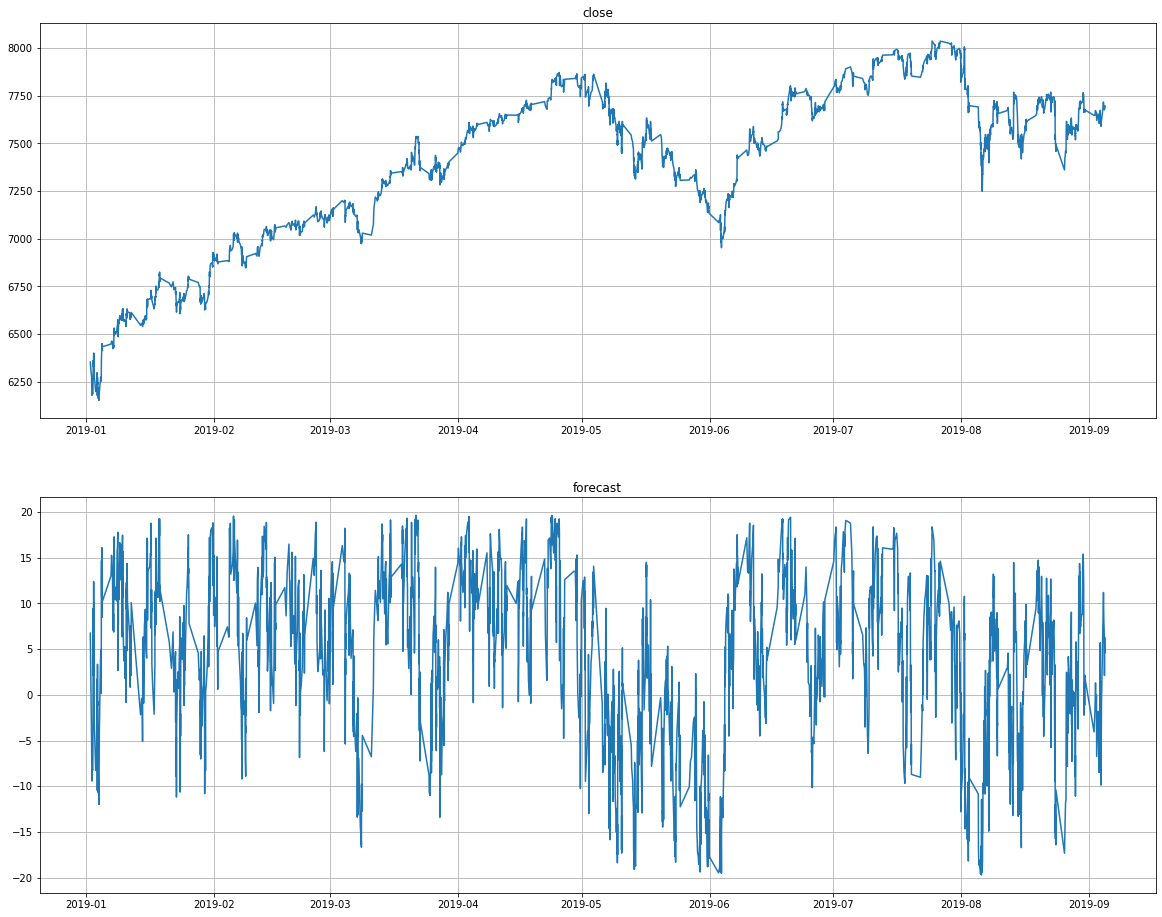

In [50]:
plot(data[['close', 'forecast']])

In [27]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.0403666,0.148377,0.0884338,0.045086,0.0759553,0.0670862,-0.0248774,0.0302765,-0.0278185
Cumulative returns,0.0273783,0.0990313,0.0595436,0.030557,0.0512374,0.0453152,-0.0170476,0.0205669,-0.0190721
Annual volatility,0.18233,0.152977,0.143132,0.137834,0.130167,0.114891,0.0688643,0.0490899,0.0166893
Sharpe ratio,0.307769,0.980511,0.663105,0.388217,0.626906,0.621941,-0.331959,0.631865,-1.68206
Calmar ratio,0.444004,2.24823,1.09878,0.606197,1.18841,0.86763,-0.464437,1.07723,-1.23091
Stability,0.253939,0.877551,0.732905,0.575726,0.622644,0.485749,0.0863244,0.234961,0.860321
Max drawdown,-0.090915,-0.0659972,-0.0804837,-0.0743752,-0.0639135,-0.0773212,-0.0535647,-0.0281058,-0.0225999
Omega ratio,1.05181,1.16918,1.11702,1.06789,1.11358,1.12577,0.906712,1.22638,0.412107
Sortino ratio,0.434084,1.50562,1.02136,0.613433,1.03692,1.12825,-0.665944,1.27497,-1.87416
Skew,-0.111853,0.267274,0.397575,0.680954,0.838547,1.43899,4.05531,3.50819,-3.40872


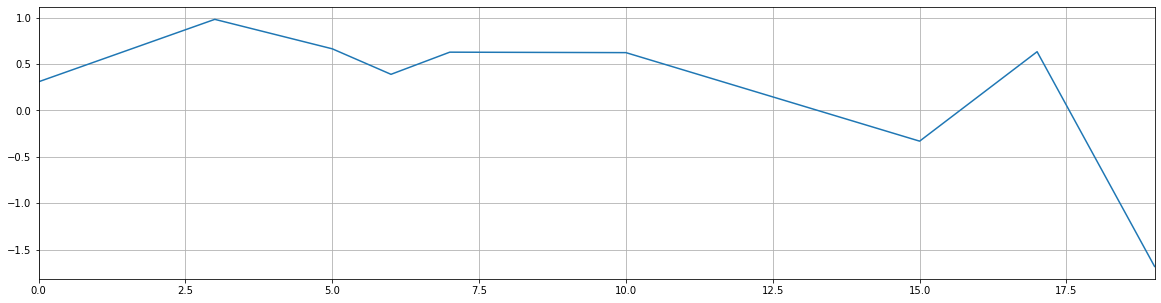

In [28]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [29]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.888725,0.784498,0.753097,0.739580,0.632425,0.385579,0.369259,-0.005541
3,0.888725,1.000000,0.904864,0.864357,0.832542,0.709802,0.433630,0.439653,-0.008332
5,0.784498,0.904864,1.000000,0.962855,0.922079,0.786274,0.507446,0.514371,-0.014218
6,0.753097,0.864357,0.962855,1.000000,0.957531,0.827498,0.537324,0.534264,-0.024593
7,0.739580,0.832542,0.922079,0.957531,1.000000,0.862371,0.530774,0.532844,-0.036594
10,0.632425,0.709802,0.786274,0.827498,0.862371,1.000000,0.607668,0.574800,-0.054283
15,0.385579,0.433630,0.507446,0.537324,0.530774,0.607668,1.000000,0.795103,-0.011448
17,0.369259,0.439653,0.514371,0.534264,0.532844,0.574800,0.795103,1.000000,0.158309
19,-0.005541,-0.008332,-0.014218,-0.024593,-0.036594,-0.054283,-0.011448,0.158309,1.000000


In [ ]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [ ]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [ ]:
np.log(out.returns[7]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [ ]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);